In [61]:
import numpy as np
from matplotlib  import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib import rc
import matplotlib.colors as colors
import scipy.stats as st
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.misc import derivative
import seaborn as sns
from seaborn import heatmap
import pandas as pd
from IPython.display import set_matplotlib_formats
import random
import time
set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": 'Computer Modern Serif'
})

/tmp/ipykernel_19747/1694429916.py:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


## Cumulative probability functions

In [2]:
def cdf(x, sigma):
    return norm.cdf(x, scale = sigma)

In [3]:
def cdfm(x, y, sigma, rho):
    return multivariate_normal([0, 0], [[sigma**2, sigma**2 * rho], [sigma**2 * rho, sigma**2]]).cdf(np.array([x,y]))

In [4]:
def cdfmsi(x, y, sigma, rho):
    return norm.cdf(y, scale = sigma) - multivariate_normal([0, 0], [[sigma**2, sigma**2 * rho], [sigma**2 * rho, sigma**2]]).cdf(np.array([x,y]))

In [5]:
def cdfmis(x, y, sigma, rho):
    return norm.cdf(x, scale = sigma) - multivariate_normal([0, 0], [[sigma**2, sigma**2 * rho], [sigma**2 * rho, sigma**2]]).cdf(np.array([x,y]))

## Market clearing equation

In [6]:
def market_clear(Pa, Pb, prop, capA, capB, prefi, prefii, sigmai, sigmaii, cori, corii):
    f1 = prop*prefi*(1 - cdf(Pa, sigmai)) + (1 - prop)*prefii*(1 - cdf(Pa, sigmaii)) + prop*(1 - prefi)*cdfmsi(Pa, Pb, sigmai, cori) + (1 -prop)*(1 - prefii)*cdfmsi(Pa, Pb, sigmaii, corii) - capA
    f2 = prop*(1 - prefi)*(1 - cdf(Pb, sigmai)) + (1 - prop)*(1 - prefii)*(1 - cdf(Pb, sigmaii)) + prop*prefi*cdfmis(Pa, Pb, sigmai, cori) + (1 -prop)*prefii*cdfmis(Pa, Pb, sigmaii, corii) - capB
    return f1, f2

In [7]:
def solv_mc(prop, capA, capB, prefi, prefii, sigmai, sigmaii, cori, corii):
    func = lambda P: market_clear(P[0], P[1], prop, capA, capB, prefi, prefii, sigmai, sigmaii, cori, corii)
    return fsolve(func, x0 = np.array([0.5, 0.5]))

## Efficiency and inequality as functions of $\theta$

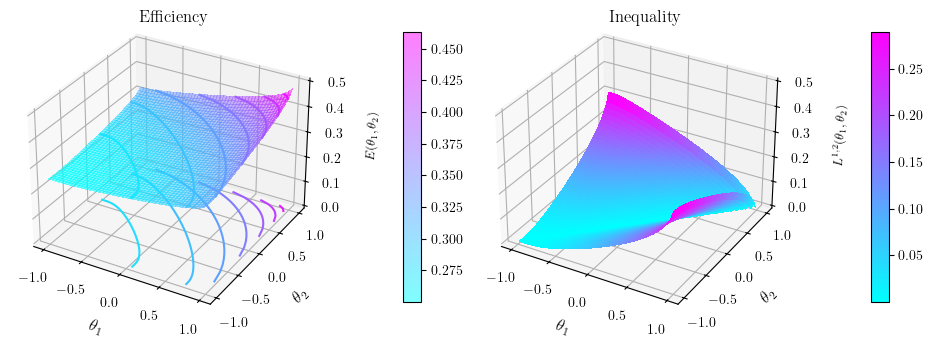

In [8]:
n_col = 2
n_groups = 2
#mean = [0, 0]
#std = [1, 1]
capacity = 0.25
sigmai = 1
sigmaii = 1
cori = 0.5
cor_min = -0.99
cor_max = 0.99
cor_step = 0.04
pref = [0.5, 0.5]
group_prop = [0.5, 0.5]
#first_2_gp = group_prop[0]*n_stud

n_points = int((cor_max-cor_min)/cor_step)
x = np.linspace(cor_min, cor_max, num = n_points)
y = np.linspace(cor_min, cor_max, num = n_points)
V = []
ineq = []
for i in range(n_points):
    cori = x[i]
    V.append([])
    ineq.append([])
    for corii in x:
        Pa, Pb = solv_mc(group_prop[0], capacity, capacity, pref[0], pref[1], sigmai, sigmaii, cori, corii)
        inq = abs(cdfm(Pa, Pb, sigmai, cori) - cdfm(Pa, Pb, sigmaii, corii))
        ineq[i].append(inq)
        V1 = group_prop[0]*pref[0]*(1 - cdf(Pa, sigmai)) + group_prop[1]*pref[1]*(1 - cdf(Pa, sigmaii)) + group_prop[0]*(1-pref[0])*(1 - cdf(Pb, sigmai)) + group_prop[1]*(1-pref[1])*(1 - cdf(Pb, sigmaii))
        V[i].append(V1)
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=plt.figaspect(0.5))
ftsize = 12
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(x, y, np.array(V), cmap = cm.cool , linewidth = 0, antialiased=False, alpha = 0.5)
ax.contour(x, y, np.array(V), cmap = cm.cool)
ax.set(zlim=(0, 0.5))
ax.contour(x, y, np.array(V), zdir='z', offset=0, cmap = cm.cool)
fig.colorbar(surf, shrink=0.6, aspect=15, pad = 0.17)
plt.xlabel(r'$\theta_1$', fontsize=ftsize, labelpad=6)
plt.ylabel(r'$\theta_2$', fontsize=ftsize, labelpad=6)
ax.set_zlabel(r'$E(\theta_1, \theta_2)$', fontsize=ftsize-3, labelpad=8)
plt.figtext(0.15, 0.8, 'Efficiency', fontsize = ftsize)
plt.tight_layout()
#ax.plot_surface(x, y, np.array(ineq), cmap=cm.cool, linewidth = 0, antialiased=False)
#ax.view_init(60, -45)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set(zlim=(0, 0.5))
surf = ax.plot_surface(x, y, np.array(ineq), cmap = cm.cool, linewidth = 0, antialiased=False)
fig.colorbar(surf, shrink=0.6, aspect=15, pad = 0.17)
plt.xlabel(r'$\theta_1$', fontsize=ftsize, labelpad=6)
plt.ylabel(r'$\theta_2$', fontsize=ftsize, labelpad=6)
ax.set_zlabel(r'$L^{1, 2}(\theta_1, \theta_2)$', fontsize=ftsize-3, labelpad=8)
plt.figtext(0.64, 0.8, 'Inequality', fontsize = ftsize)
plt.tight_layout()

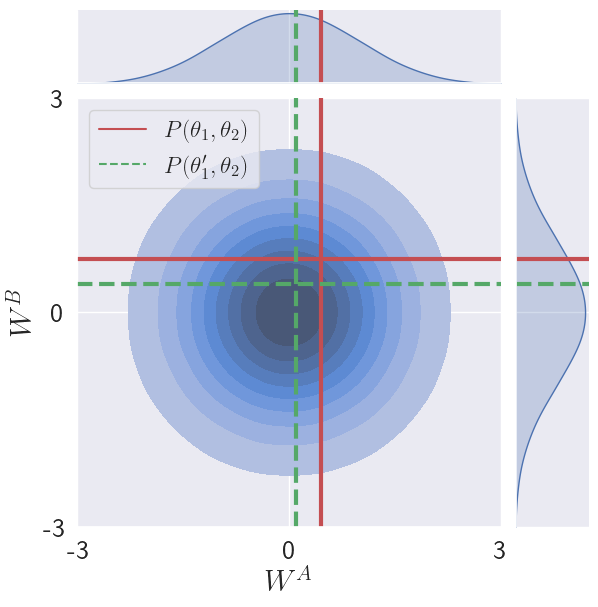

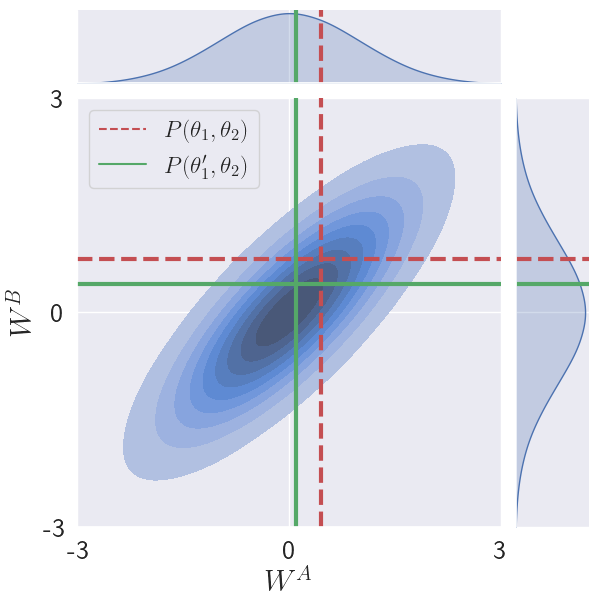

In [12]:
sns.set(color_codes=True)
color1 = 'r'
color2 = 'g'
cutA1 = 0.45
cutA2 = 0.1
cutB1 = 0.75
cutB2 = 0.4
font_lab = 22
font_ticks = 20
font_legend = 17

grid = 50
n_points = 300
array = np.linspace(-3, 3, grid)


distrib = np.array([[multivariate_normal([0, 0], [[1, 0], [0, 1]]).pdf(np.array([x, y])) for y in array] for x in array])
data = []
for i in range(grid):
    for j in range(grid):
        for k in range(int(n_points * distrib[i, j])):
            data.append([array[i], array[j]])
trp = np.transpose(np.array(data))
data = pd.DataFrame({'x': trp[0], 'y': trp[1]})

plot = sns.jointplot(x = 'x', y = 'y', data=data, kind = 'kde', fill = 'True')
plot.ax_marg_x.set_xlim(-3, 3)
plot.ax_marg_y.set_ylim(-3, 3)
plot.set_axis_labels(r'$W^A$', r'$W^B$', fontsize=font_lab)
plot.ax_joint.set_xticks([-3, 0, 3])
plot.ax_joint.set_xticklabels(['-3', '0', '3'], fontsize=font_ticks)
plot.ax_joint.set_yticks([-3, 0, 3])
plot.ax_joint.set_yticklabels(['-3', '0', '3'], fontsize=font_ticks)
plot.ax_joint.axvline(x = cutA1, color = color1, linewidth = 3)
plot.ax_joint.axhline(y = cutB1, color = color1, linewidth = 3)
plot.ax_joint.axvline(x = cutA2, color = color2, linestyle = '--', linewidth = 3)
plot.ax_joint.axhline(y = cutB2, color = color2, linestyle = '--', linewidth = 3)
plot.ax_marg_x.axvline(x = cutA1, color = color1, linewidth = 3)
plot.ax_marg_y.axhline(y = cutB1, color = color1, linewidth = 3)
plot.ax_marg_x.axvline(x = cutA2, color = color2, linestyle = '--', linewidth = 3)
plot.ax_marg_y.axhline(y = cutB2, color = color2, linestyle = '--', linewidth = 3)
plain = mlines.Line2D([], [], color=color1, label=r"$P(\theta_1, \theta_2)$")
dashes = mlines.Line2D([], [], color=color2, label=r"$P(\theta_1', \theta_2)$", linestyle = 'dashed')
plot.ax_joint.legend(handles=[plain, dashes], loc = 2, fontsize = font_legend)
plot.savefig('Figures/cutoff_shift_pt1.pdf')


distrib = np.array([[multivariate_normal([0, 0], [[1, 0.8], [0.8, 1]]).pdf(np.array([x, y])) for y in array] for x in array])
data = []
for i in range(grid):
    for j in range(grid):
        for k in range(int(n_points * distrib[i, j])):
            data.append([array[i], array[j]])
trp = np.transpose(np.array(data))
data = pd.DataFrame({'x': trp[0], 'y': trp[1]})

plot = sns.jointplot(x = 'x', y = 'y', data=data, kind = 'kde', fill = 'True')
plot.ax_marg_x.set_xlim(-3, 3)
plot.ax_marg_y.set_ylim(-3, 3)
plot.set_axis_labels(r'$W^A$', r'$W^B$', fontsize=font_lab)
plot.ax_joint.set_xticks([-3, 0, 3])
plot.ax_joint.set_xticklabels(['-3', '0', '3'], fontsize=font_ticks)
plot.ax_joint.set_yticks([-3, 0, 3])
plot.ax_joint.set_yticklabels(['-3', '0', '3'], fontsize=font_ticks)
plot.ax_joint.axvline(x = cutA1, color = color1, linestyle = '--', linewidth = 3)
plot.ax_joint.axhline(y = cutB1, color = color1, linestyle = '--', linewidth = 3)
plot.ax_joint.axvline(x = cutA2, color = color2, linewidth = 3)
plot.ax_joint.axhline(y = cutB2, color = color2, linewidth = 3)
plot.ax_marg_x.axvline(x = cutA1, color = color1, linestyle = '--', linewidth = 3)
plot.ax_marg_y.axhline(y = cutB1, color = color1, linestyle = '--', linewidth = 3)
plot.ax_marg_x.axvline(x = cutA2, color = color2, linewidth = 3)
plot.ax_marg_y.axhline(y = cutB2, color = color2, linewidth = 3)
plain = mlines.Line2D([], [], color=color1, label=r"$P(\theta_1, \theta_2)$", linestyle = 'dashed')
dashes = mlines.Line2D([], [], color=color2, label=r"$P(\theta_1', \theta_2)$")
plot.ax_joint.legend(handles=[plain, dashes], loc = 2, fontsize = font_legend)

# Market Clearing Equation (4 colleges)

In [29]:
def cdf(x, mu, sigma):
    return norm.cdf(x, scale = sigma)

In [30]:
def cdfm(x, mu, sigma, rho):
    d = mu.__len__()
    cov = np.ones((d, d)) * rho
    for i in range(d):
        cov[i, i] = 1
        cov[i] = cov[i]*sigma[i]
        cov[:, i] = cov[:, i] * sigma[i]
    return multivariate_normal(mu, cov).cdf(np.array(x))

In [31]:
def cdfmsi(x, y, sigma, rho):
    return norm.cdf(y, scale = sigma) - multivariate_normal([0, 0], [[sigma**2, sigma**2 * rho], [sigma**2 * rho, sigma**2]]).cdf(np.array([x,y]))

In [32]:
def cdfmis(x, y, sigma, rho):
    return norm.cdf(x, scale = sigma) - multivariate_normal([0, 0], [[sigma**2, sigma**2 * rho], [sigma**2 * rho, sigma**2]]).cdf(np.array([x,y]))

### For simplicity, we consider only the preference lists: [0, 1, 2, 3], [1, 3, 0, 2], [2, 0, 3, 1], [3, 2, 1, 0]

In [33]:
def market_clear_d4_K1(P, cap, pref, mu, sigma, cor):
    f0 = pref[0]*(1 - cdf(P[0], mu[0], sigma[0])) + pref[1]*(cdfm([P[1], P[3]], [mu[1], mu[3]], [sigma[1], sigma[3]], cor) - cdfm([P[0], P[1], P[3]], [mu[0], mu[1], mu[3]], [sigma[0], sigma[1], sigma[3]], cor)) + pref[2]*(cdf(P[2], mu[2], sigma[2]) - cdfm([P[0], P[2]], [mu[0], mu[2]], [sigma[0], sigma[2]], cor))+ pref[3]*(cdfm([P[1], P[2], P[3]], [mu[1], mu[2], mu[3]], [sigma[1], sigma[2], sigma[3]], cor) - cdfm(P, mu, sigma, cor)) - cap[0]
    f1 = pref[1]*(1 - cdf(P[1], mu[1], sigma[1])) + pref[3]*(cdfm([P[2], P[3]], [mu[2], mu[3]], [sigma[2], sigma[3]], cor) - cdfm([P[1], P[2], P[3]], [mu[1], mu[2], mu[3]], [sigma[1], sigma[2], sigma[3]], cor)) + pref[0]*(cdf(P[0], mu[0], sigma[0]) - cdfm([P[0], P[1]], [mu[0], mu[1]], [sigma[0], sigma[1]], cor))+ pref[2]*(cdfm([P[0], P[2], P[3]], [mu[0], mu[2], mu[3]], [sigma[0], sigma[2], sigma[3]], cor) - cdfm(P, mu, sigma, cor)) - cap[1]
    f2 = pref[2]*(1 - cdf(P[2], mu[2], sigma[2])) + pref[0]*(cdfm([P[0], P[1]], [mu[0], mu[1]], [sigma[0], sigma[1]], cor) - cdfm([P[0], P[1], P[2]], [mu[0], mu[1], mu[2]], [sigma[0], sigma[1], sigma[2]], cor)) + pref[3]*(cdf(P[3], mu[3], sigma[3]) - cdfm([P[3], P[2]], [mu[3], mu[2]], [sigma[3], sigma[2]], cor))+ pref[1]*(cdfm([P[1], P[0], P[3]], [mu[1], mu[0], mu[3]], [sigma[1], sigma[0], sigma[3]], cor) - cdfm(P, mu, sigma, cor)) - cap[2]
    f3 = pref[3]*(1 - cdf(P[3], mu[3], sigma[3])) + pref[2]*(cdfm([P[0], P[2]], [mu[0], mu[2]], [sigma[0], sigma[2]], cor) - cdfm([P[0], P[2], P[3]], [mu[0], mu[2], mu[3]], [sigma[0], sigma[2], sigma[3]], cor)) + pref[1]*(cdf(P[1], mu[1], sigma[1]) - cdfm([P[1], P[3]], [mu[1], mu[3]], [sigma[1], sigma[3]], cor))+ pref[0]*(cdfm([P[1], P[2], P[0]], [mu[1], mu[2], mu[0]], [sigma[1], sigma[2], sigma[0]], cor) - cdfm(P, mu, sigma, cor)) - cap[3]
    return np.array([f0, f1, f2, f3])

In [34]:
def solv_mc_d4_K1(cap, pref, mu, sigma, cor):
    func = lambda P: np.linalg.norm(market_clear_d4_K1(P, cap, pref, mu, sigma, cor))
    return minimize(func, x0 = np.array([1, 1, 1, 1]), method = 'Nelder-Mead', tol = 10**(-5))

cor =  0.01
P =  [ 1.33444369  1.37134069  0.45532637 -0.37998504]
obj =  5.454764856505853e-07
success:  True
cor =  0.04379310344827586
P =  [ 1.31341357  1.35643286  0.43484653 -0.40011543]
obj =  1.8418453063161181e-06
success:  True
cor =  0.07758620689655171
P =  [ 1.29231293  1.3417294   0.41430589 -0.42012661]
obj =  2.750162569340237e-06
success:  True
cor =  0.11137931034482758
P =  [ 1.27117601  1.32720673  0.3937251  -0.44003779]
obj =  4.33245407268774e-07
success:  True
cor =  0.14517241379310344
P =  [ 1.25002303  1.31285652  0.37315875 -0.45978421]
obj =  2.194658218293609e-06
success:  True
cor =  0.1789655172413793
P =  [ 1.22877263  1.29862362  0.3525761  -0.47940118]
obj =  1.5777927147593701e-06
success:  True
cor =  0.21275862068965518
P =  [ 1.20759351  1.28444349  0.33201777 -0.49882844]
obj =  8.722581586111006e-07
success:  True
cor =  0.24655172413793103
P =  [ 1.18636829  1.27031498  0.31145378 -0.51812625]
obj =  6.408090490266844e-07
success:  True
cor =  

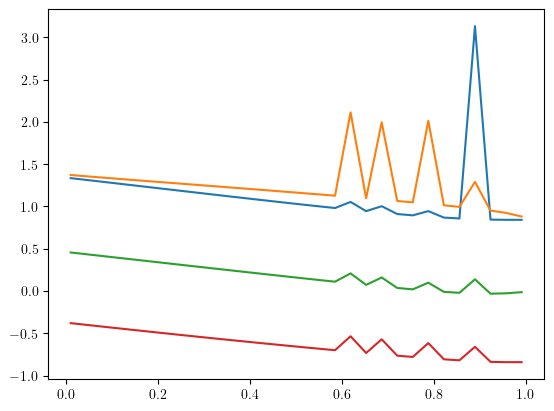

In [34]:
n_col = 4
n_groups = 1
#mean = [0, 0]
#std = [1, 1]
cap = [0.05, 0.05, 0.2, 0.5]
pref = [0.25, 0.25, 0.25, 0.25]
mu = [0, 0, 0, 0]
sigma = [1, 1, 1, 1]
cor_min = 0.01
cor_max = 0.99
n_points_cor = 30
#first_2_gp = group_prop[0]*n_stud

x_cor = np.linspace(cor_min, cor_max, num = n_points_cor)
cut = []
for cor in x_cor:
    print('cor = ', cor)
    sol = solv_mc_d4_K1(cap, pref, mu, sigma, cor)
    P = sol.__getitem__('x')
    print('P = ', P)
    print('obj = ', sol.__getitem__('fun'))
    print('success: ', sol.__getitem__('success'))
    cut.append(P)
    #print('sucess, P = ', P, "res = ", np.array(market_clear_d4_K1(P, cap, pref, mu, sigma, cor)/100))
cut = np.array(cut)
plt.plot(x_cor, np.array(cut)[:, 0])
plt.plot(x_cor, np.array(cut)[:, 1])
plt.plot(x_cor, np.array(cut)[:, 2])
plt.plot(x_cor, np.array(cut)[:, 3])
plt.show()



### Some values are wrong due to the solver failing to solve the market clearing equation. We remove those points, this has no incidence on the result: the cutoffs are non-monotonic even without those points

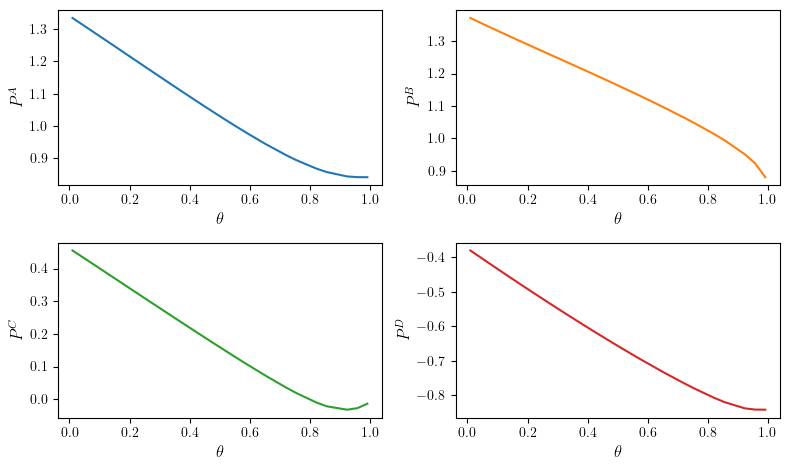

In [35]:
cut[-4] = 0.5*(cut[-3] + cut[-5])
cut[-7] = 0.5*(cut[-6] + cut[-8])
cut[-10] = 0.5*(cut[-9] + cut[-11])
cut[-12] = 0.5*(cut[-11] + cut[-13])

ftsize = 12

fig= plt.figure(figsize=plt.figaspect(0.6))
ax = fig.add_subplot(2, 2, 1)
ax.plot(x_cor, cut[:, 0], color = sns.color_palette()[0])
plt.xlabel(r'$\theta$', fontsize=ftsize)
plt.ylabel(r'$P^A$', fontsize=ftsize)

ax = fig.add_subplot(2, 2, 2)
ax.plot(x_cor, cut[:, 1], color = sns.color_palette()[1])
plt.xlabel(r'$\theta$', fontsize=ftsize)
plt.ylabel(r'$P^B$', fontsize=ftsize)

ax = fig.add_subplot(2, 2, 3)
ax.plot(x_cor, cut[:, 2], color = sns.color_palette()[2])
plt.xlabel(r'$\theta$', fontsize=ftsize)
plt.ylabel(r'$P^C$', fontsize=ftsize)

ax = fig.add_subplot(2, 2, 4)
ax.plot(x_cor, cut[:, 3], color = sns.color_palette()[3])
plt.xlabel(r'$\theta$', fontsize=ftsize)
plt.ylabel(r'$P^D$', fontsize=ftsize)

plt.tight_layout()
#plt.subplots_adjust(left=0.07,
#                    bottom=0.1, 
#                    right=0.93, 
#                    top=0.9, 
#                    wspace=0.4, 
#                    hspace=0.8)
plt.savefig("Figures/counter.pdf", bbox_inches='tight' )

# Gale-Shapley simulation framework for two colleges

## Creates a table of students. Each vector in the list is a group, each element is the latent quality of a student.

### Arguments: Number of students, proportion of each group, mean of each group's latent quality, standard deviation of each group's latent quality
### Output: Table of students

In [6]:
def create_students(n_stud: int, prop_gp: list, mean_gp: list, std_gp: list):
    n_gp = prop_gp.__len__()
    n_gp1 = mean_gp.__len__()
    n_gp2 = std_gp.__len__()
    if ((n_gp==n_gp1) and (n_gp==n_gp2)) == False:
        print("group arguments of different sizes")
        return 0
    s = 0
    for i in range(n_gp):
        if ((prop_gp[i] < 0) or (prop_gp[i] > 1)):
            print("wrong proportions")
            return 0
        s = s + prop_gp[i]
    if ((s<0.99) or (s>1.01)):
        print("wrong proportions")
        return 0
    nb_stud_gp = [int(x*n_stud) for x in prop_gp]
    students = []
    for i in range(n_gp):
        stud_gp = np.random.normal(mean_gp[i], std_gp[i], nb_stud_gp[i])
        students.append(stud_gp)
    return students

## Creates noisy estimates of students qualities for a variable number of colleges. The output is a list of tables of the same format that the students table, one for each college. The bias and standard devaition are group-dependant and common to all colleges, but each college randomly draws an independant value.

### Arguments: Number of colleges, students latent qualities table, bias for each group, standard deviation for each group
### Output: List of student-like tables

### Grades: Latent quality + noise

In [3]:
def create_col_estim(n_col,students, noise_mean, noise_std):
    n_gp = noise_mean.__len__()
    n_gp1 = noise_std.__len__()
    n_gp2 = students.__len__()
    if ((n_gp==n_gp1) and (n_gp==n_gp2)) == False:
        print("group arguments of different sizes")
        return 0
    col_estim = []
    for i in range (n_col):
        estim = students.copy()
        for j in range(n_gp):
            m = students[j].size
            noise = np.random.normal(noise_mean[j], noise_std[j], m)
            estim[j] = students[j] + noise
        col_estim.append(estim)
    return col_estim

In [41]:
def create_col_estim_test(n_col,students, noise_mean, noise_std):
    n_gp = noise_mean.__len__()
    n_gp1 = noise_std.__len__()
    n_gp2 = students.__len__()
    if ((n_gp==n_gp1) and (n_gp==n_gp2)) == False:
        print("group arguments of different sizes")
        return 0
    col_estim = []
    for i in range (n_col):
        estim = students.copy()
        print('student: ', students)
        print('estim init: ', estim)
        for j in range(n_gp):
            m = students[j].size
            noise = np.random.normal(noise_mean[j], noise_std[j], m)
            estim[j] = students[j] + noise
        col_estim.append(estim)
        print('College estim:', col_estim)
    return col_estim

In [12]:
students = create_students(5, [0.4, 0.6], [10, 10], [2, 2])
col = create_col_estim_test(2, students, [10, 10], [2, 2])
print(students)
print (col)

student:  [array([13.56738166, 11.33067904]), array([13.04556139,  9.27538216, 14.6826008 ])]
estim init:  [array([13.56738166, 11.33067904]), array([13.04556139,  9.27538216, 14.6826008 ])]
student:  [array([13.56738166, 11.33067904]), array([13.04556139,  9.27538216, 14.6826008 ])]
estim init:  [array([13.56738166, 11.33067904]), array([13.04556139,  9.27538216, 14.6826008 ])]
[array([13.56738166, 11.33067904]), array([13.04556139,  9.27538216, 14.6826008 ])]
[[array([19.45817802, 18.1144809 ]), array([22.036067  , 19.52039221, 26.60658846])], [array([20.9451988 , 21.06425054]), array([24.52579775, 19.23704785, 27.07470654])]]


### Grades: weighted mean between latent quality and noise, weight = noise_amount

In [7]:
def create_col_estim_var(n_col,students, noise_ammount, mean, noise_std):
    n_gp = mean.__len__()
    n_gp2 = students.__len__()
    if  (n_gp==n_gp2) == False:
        print("group arguments of different sizes")
        return 0
    col_estim = []
    for i in range (n_col):
        estim = students.copy()
        for j in range(n_gp):
            m = students[j].size
            group = np.zeros(m)
            for stud in range(m):
                noise = np.random.normal(mean[j], noise_std)
                group[stud] = (((1-noise_ammount[j])*students[j][stud] + noise_ammount[j]*noise)/(np.sqrt(noise_ammount[j]**2 + (1-noise_ammount[j])**2)))
            estim[j] = group
        col_estim.append(estim)
    return col_estim

In [8]:
group = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], size = 5)
print(group)
print(np.transpose(group)[0])

[[ 0.78402634 -0.35870189]
 [-2.88675477 -1.75529278]
 [ 1.0463409   0.07891172]
 [ 0.01339698 -0.38383943]
 [ 0.14489847 -1.02175022]]
[ 0.78402634 -2.88675477  1.0463409   0.01339698  0.14489847]


### Grades: bivariate gaussian

In [9]:
def create_col_estim_biv(n_col,students, mean, std, corr):
    n_gp = mean.__len__()
    n_gp2 = students.__len__()
    if  (n_gp==n_gp2) == False:
        print("group arguments of different sizes")
        return 0
    col_estim = [[], []]
    for j in range(n_gp):
        m = students[j].size
        group = np.random.multivariate_normal([mean[j], mean[j]], [[std[j]**2, (std[j]**2)*corr[j]], [(std[j]**2)*corr[j], std[j]]], size = m)
        estim_A = np.transpose(group)[0]
        estim_B = np.transpose(group)[1]
        col_estim[0].append(estim_A)
        col_estim[1].append(estim_B)
    return col_estim

## Creates student preferences. Returns the student table but with a list of preferences instead of the quality of each student. The preferences are sampled uniformly across all permutations.

### Arguments: Students table, number of colleges
### Output: Student-like table, each element is a permutation of [1, m] (m = number of colleges)

In [20]:
def create_stud_pref(students:list, n_col:int):
    stud_pref=[]
    for i in range(students.__len__()):
        group = []
        for j in range(students[i].size):
            group.append(random.sample(range(n_col), n_col))
        stud_pref.append(group)
    return stud_pref

In [21]:
create_stud_pref(students,3)

[[[1, 2, 0], [2, 1, 0]], [[2, 0, 1], [2, 0, 1], [1, 2, 0]]]

## Creates preferences in a 2 colleges problem, with control over the distribution of preferences.

### Arguments: Students table, proportion of students who prefer college 0
### Output: Same as function above

In [22]:
def create_stud_pref_2(students, prop_0):
    stud_pref=[]
    for i in range(students.__len__()):
        group = []
        for j in range(students[i].size):
            rand = np.random.rand()
            if rand < prop_0:
                group.append([0,1])
            else:
                group.append([1,0])
        stud_pref.append(group)
    return stud_pref

In [26]:
test_stud_pref = create_stud_pref_2(students,0.4)
print(test_stud_pref)

[[[0, 1], [0, 1]], [[0, 1], [1, 0], [0, 1]]]


## Creates preferences in a 2 colleges problem, with control over the distribution of preferences. The proportions are deterministically respected: the number of students with each prioriry profile is exact

### Arguments: Students table, proportion of students who prefer college 0
### Output: Same as function above

In [12]:
def create_stud_pref_3(students, prop_0):
    stud_pref=[]
    for i in range(students.__len__()):
        group = []
        for j in range(students[i].size):
            if j < students[i].size*prop_0:
                group.append([0,1])
            else:
                group.append([1,0])
        stud_pref.append(group)
    return stud_pref

In [13]:
def create_stud_pref_groups(students, prop_0):
    stud_pref=[]
    for i in range(students.__len__()):
        group = []
        for j in range(students[i].size):
            if j < students[i].size*prop_0[i]:
                group.append([0,1])
            else:
                group.append([1,0])
        stud_pref.append(group)
    return stud_pref

## Transforms a preferences table to a table containing, for each student, the rank she attributed to each college (element i, j = rank of college j for student i)

In [24]:
def pref_to_rank(stud_pref):
    stud_rank = []
    n_col = stud_pref[0][0].__len__()
    for i in range(stud_pref.__len__()):
        group = []
        for j in range (stud_pref[i].__len__()):
            pref = stud_pref[i][j]
            rank = np.zeros(n_col)
            for k in range(n_col):
                rank[stud_pref[i][j][k]] = k
            group.append(rank)
        stud_rank.append(group)
    return stud_rank

In [27]:
pref_to_rank(test_stud_pref)

[[array([0., 1.]), array([0., 1.])],
 [array([0., 1.]), array([1., 0.]), array([0., 1.])]]

## Takes a table of students grades (latent or estimated) and outputs a table of the same format containing the ranking of each student instead of her grade.

### Arguments: Students table or estimated qualities table
### Output: Student-like table, each element is the ranking of the student for the input quality esimator

In [64]:
def grades_to_rank (students):
    grades = []
    for i in range (students.__len__()):
        for j in range (students[i].size):
            grades.append(students[i][j])
    positions = sorted(range(len(grades)), key=lambda x : grades[x], reverse=True) #If student i is ranked j-th, then position[j] = i
    ranks = sorted(range(len(grades)), key=lambda x : positions[x], reverse=False) #If student i is ranked j-th, then rank[i] = j
    rank = []
    count = 0
    for i in range(students.__len__()):
        group = []
        for j in range(students[i].size):
            group.append(ranks[count + j])
        rank.append(group)
        count = count + students[i].size
    return rank

In [65]:
grades_to_rank(students)

[[1, 3], [2, 4, 0]]

In [66]:
students

[array([13.56738166, 11.33067904]),
 array([13.04556139,  9.27538216, 14.6826008 ])]

## Applies the previous function to all colleges estimators. Outputs a list of one table per college.

### Arguments: Colleges estimations
### Output: List of ranking tables

In [67]:
def glob_grades_to_rank(col_estim):
    n_col = col_estim.__len__()
    glob_rank=[]
    for i in range(n_col):
        glob_rank.append(grades_to_rank(col_estim[i]))
    return glob_rank

In [68]:
glob_grades_to_rank(col)

[[[3, 4], [1, 2, 0]], [[3, 2], [1, 4, 0]]]

## Takes a student_like table and flattens it - i.e. remove the group format.

### Argument: Student table
### Output: Student table without groups (one less dimension)

In [69]:
def flatten_simple(student_table):
    flat = []
    for j in range (student_table.__len__()):
        for k in range (student_table[j].__len__()):
            flat.append(student_table[j][k])
    return flat

## Applies the previous function to a list of student tables.

### Input: List of student tables
### Output: List of flattened student tables

In [70]:
def flatten(student_table_list):
    n_col = student_table_list.__len__()
    flat = []
    for i in range (n_col):
        col = []
        for j in range (student_table_list[i].__len__()):
            for k in range (student_table_list[i][j].__len__()):
                col.append(student_table_list[i][j][k])
        flat.append(col)
    return flat

## Transform a flat matching into a group matching

In [71]:
def flat_to_group_match(student, matching):
    n_col = matching.__len__()
    n_group = student.__len__()
    group_begin = [0]
    t = 0
    for i in range(1, n_group):
        t = t + student[i-1].__len__()
        group_begin.append(t)
    group_match = []
    for i in range(n_col):
        group_match.append([])
        for j in range(n_group):
            group_match[i].append([])
        for stud in matching[i]:
            k = 1
            while (stud >= group_begin[k]):
                k += 1
                if (k == n_group):
                    break
            group_match[i][k-1].append(stud)
    return group_match
    

# Implementation of the standard Gale-Shapley algorithm (without groups).

## Test version with prints

### Arguments: Students preferences, list of college rabkings, list of college capacities
### Output: List of the students matched to each college

In [83]:
def GS_no_groups_test (stud_pref, glob_rank, capacities):
    start_time = time.time()
    n_col = glob_rank.__len__()
    prefs = flatten_simple(stud_pref)
    print("preferences_flat: ", prefs)
    n_stud = prefs.__len__()
    glob = flatten(glob_rank)
    print("ranks_flat ", glob)
    matching = []
    for i in range (n_col):
        matching.append([])
    print("empty matching: ", matching)
    worst_student = np.full(n_col, -1)
    not_finished = True
    pref_iterator = np.zeros(n_stud, dtype = int)
    matched = np.full(n_stud, False, dtype=bool)
    finished = np.full(n_stud, False, dtype=bool)
    print("matched initial: ", matched)
    loop = 0
    while (not_finished):
        loop += 1
        print("loop ", loop)
        matched_temp = matched.copy()
        for i in range(n_stud):
            print("student ", i)
            if (matched_temp[i] == True):
                print("matched at beginning of loop")
                continue
            if (matched[i]==False) and (finished[i]==False):
                print("not matched yet")
                application = prefs[i][pref_iterator[i]]
                if capacities[application] == 0:
                    pref_iterator[i] += 1
                    if pref_iterator[i] >= n_col:
                        finished[i] = True
                    continue
                print ("applies to ", application)
                print("capacity: ", capacities[application])
                print("current students: ", matching[application])
                print("ranking: ", glob[application])
                worst = worst_student[application]
                print("worst student: ", worst)
                if matching[application].__len__() < capacities[application]:
                    matching[application].append(i)
                    matched[i] = True
                    if worst == -1:
                        worst_student[application] = i
                    else:
                        if glob[application][i] > glob[application][worst]:
                            worst_student[application] = i
                    print("new students: ", matching[application])
                    print("matched: " , matched)
                    print("new worst: ", worst_student[application])
                else:
                    if glob[application][i] < glob[application][worst]:
                        matching[application].remove(worst)
                        matched[worst] = False
                        matching[application].append(i)
                        matched[i] = True
                        new_worst = sorted(matching[application], key = lambda x : glob[application][x], reverse = True)[0]
                        worst_student[application] = new_worst
                        print("added ", i, ", removed ", worst)
                        print("new students: ", matching[application])
                        print("matched: ", matched)
                        print("new worst: ", worst_student[application])
                pref_iterator[i] += 1
                print("pref_iterator: ", pref_iterator[i])
            if pref_iterator[i] >= n_col:
                finished[i] = True
        if (all(matched | finished) == True):
            not_finished = False
    print(loop, " loops")
    print("--- %s seconds ---" % (time.time() - start_time))
    return matching

## Normal version

In [53]:
def GS_no_groups (stud_pref, glob_rank, capacities):
    start_time = time.time()
    n_col = glob_rank.__len__()
    prefs = flatten_simple(stud_pref)
    n_stud = prefs.__len__()
    glob = flatten(glob_rank)
    matching = []
    for i in range (n_col):
        matching.append([])
    worst_student = np.full(n_col, -1)
    not_finished = True
    pref_iterator = np.zeros(n_stud, dtype = int)
    matched = np.full(n_stud, False, dtype=bool)
    finished = np.full(n_stud, False, dtype=bool)
    while (not_finished):
        matched_temp = matched.copy()
        for i in range(n_stud):
            if (matched_temp[i] == True): continue
            if (matched[i]==False) and (finished[i]==False):
                application = prefs[i][pref_iterator[i]]
                if capacities[application] == 0:
                    pref_iterator[i] += 1
                    if pref_iterator[i] >= n_col:
                        finished[i] = True
                    continue
                worst = worst_student[application]
                if matching[application].__len__() < capacities[application]:
                    matching[application].append(i)
                    matched[i] = True
                    if worst == -1:
                        worst_student[application] = i
                    else:
                        if glob[application][i] > glob[application][worst]:
                            worst_student[application] = i
                else:
                    if glob[application][i] < glob[application][worst]:
                        matching[application].remove(worst)
                        matched[worst] = False
                        matching[application].append(i)
                        matched[i] = True
                        new_worst = sorted(matching[application], key = lambda x : glob[application][x], reverse = True)[0]
                        worst_student[application] = new_worst
                pref_iterator[i] += 1
            if pref_iterator[i] >= n_col:
                finished[i] = True
        if (all(matched | finished) == True):
            not_finished = False
    
    #print("--- %s seconds ---" % (time.time() - start_time))
    return matching

## Implementation of GS with groups

In [87]:
def GS_groups (stud_pref, glob_rank, capacities):
    matching_flat = GS_no_groups(stud_pref, glob_rank, capacities)
    group_match = flat_to_group_match(stud_pref, matching_flat)
    return group_match

In [88]:
def GS_groups_test (stud_pref, glob_rank, capacities):
    matching_flat = GS_no_groups_test(stud_pref, glob_rank, capacities)
    group_match = flat_to_group_match(stud_pref, matching_flat)
    return group_match

## Compute colleges payoff

### Input: Student's table, matching

### Output: List of each college's payoff

In [24]:
def college_payoff (students, matching):
    payoffs = []
    mean_payoffs = []
    grades = flatten_simple(students)
    m = matching.__len__()
    for c in range(m):
        payoff = 0
        k = matching[c].__len__()
        if k == 0: 
            payoffs.append(payoff)
            mean_payoffs.append(payoff)
            continue
        for s in range(k):
            payoff += grades[matching[c][s]]
        payoffs.append(payoff)
        mean_payoffs.append(payoff/k)
    return payoffs, mean_payoffs

## Transform a matching that gives the list of student at each college to a matching that gives each student's college.

### Input: Matching given by GS, number of students
### Output: List of each student's college in the matching

In [25]:
def invertGS (matching, n_stud):
    stud_match = -1*np.ones(n_stud)
    for i in range (matching.__len__()):
        for j in range (matching[i].__len__()):
            stud_match[matching[i][j]] = i
    return stud_match

## Compute the proportion of student benefitting or losing from the imperfection of the estimation.

### Arguments: Students table, number of students, student's preferences, global ranking, colleges capacities
### Output: Proportion of students benefitting from the noise, proportion of students losing from it

In [26]:
def noise_effect(matching, students, n_stud, stud_pref, glob_rank, capacities):
    noisyGS = matching
    n_col = glob_rank.__len__()
    rank=[]
    for i in range(n_col):
        rank.append(grades_to_rank(students))
    perfectGS = GS_no_groups(stud_pref, rank, capacities)
    #print("perfect GS", perfectGS)
    stud_rank = flatten_simple(pref_to_rank(stud_pref))
    stud1 = invertGS(noisyGS, n_stud)
    stud2 = invertGS(perfectGS, n_stud)
    better = 0
    worse = 0
    for i in range(n_stud):
        noisy_col = int(stud1[i])
        normal_col = int(stud2[i])
        if noisy_col >= 0:
            noisy = stud_rank[i][noisy_col]
        else:
            noisy = -1
        if normal_col >= 0:
            normal = stud_rank[i][normal_col]
        else:
            normal = -1        
        if (noisy < normal and noisy>=0):
            better += 1
        if (noisy < normal and noisy<0):
            worse +=1
        if (noisy > normal and normal>=0):
            worse +=1
        if (noisy > normal and normal<0):
            better +=1
    #print("students benefiting from the noise: ", 100*better/n_stud, "%")
    #print("students losing from the noise: ", 100*worse/n_stud, "%")
    #print("students indiferrent: ", 100*(n_stud - better - worse)/n_stud, "%")
    return 100*better/n_stud, 100*worse/n_stud

## Find the rank of the worst student admitted at each college.

### Arguments: Matching, ranking
### Output: List containing the rank of the worst student admitted at each college

In [27]:
def find_worst_stud(matching, glob_rank):
    n_col = matching.__len__()
    worst_stud = np.zeros(n_col)
    rank = flatten(glob_rank)
    for i in range(n_col):
        stud = matching[i]
        if not stud:
            worst_stud[i] = -1
            continue
        n_stud = stud.__len__()
        pos = rank[i]
        worst = pos[stud[0]]
        for j in range (n_stud):
            if pos[stud[j]] > worst:
                worst = pos[stud[j]]
        worst_stud[i] = worst
    return worst_stud

## Compute the average number of blocking pair per student, and the proportion of students suffering from a blocking pair (either justified envy or waste), given a reference ranking.

### Arguments: Matching, number of students, number of colleges, students preferences, reference ranking, capacities
### Output: number of blocking pair per student, proportion of students suffering from a blocking pair

In [28]:
def blocking_pairs(matching, n_stud, n_col, stud_pref, true_rank, capacities):
    stud_match = invertGS(matching, n_stud)
    bp = 0
    bp_temp = 0
    bs = 0
    rank = flatten(true_rank)
    worst_stud = find_worst_stud(matching, true_rank)
    #print(worst_stud)
    stud_pref_flat = flatten_simple(stud_pref)
    for i in range(n_stud):
        col = stud_match[i]
        if stud_pref_flat[i][0] == col:
            continue
        j = 0
        better_col = stud_pref_flat[i][j]
        while (better_col != col):
            if matching[better_col].__len__() < capacities[better_col]:
                bp_temp += 1
                #print("blocking pair: student ", i, "and college ", better_col)
                j += 1
                if j >= n_col:
                    break
                better_col = stud_pref_flat[i][j]
                continue
            worst = worst_stud[better_col]
            pos = rank[better_col][i]
            if worst > pos:
                bp_temp += 1
                #print("blocking pair: student ", i, "and college ", better_col)
            j += 1
            if j >= n_col:
                break
            better_col = stud_pref_flat[i][j]
        if bp_temp>bp:
            bs += 1
        bp =  bp_temp
    #print(bp/n_stud, " blocking pair per student")
    #print(100*bs/n_stud, "% of students involved in a blocking pair")
    return bp/n_stud, 100*bs/n_stud

## Create a glob_rank-like list, containing only copies of the true ranking, one for each college.

### Arguments: Students table, number of colleges
### Output: List containing the true ranking n_col times

In [29]:
def true_rank_to_glob(students, n_col):
    glob_grades = []
    for i in range (n_col):
        glob_grades.append(students)
    glob_rank = glob_grades_to_rank(glob_grades)
    return glob_rank

## Creates an instance of the problem, computes the matching and runs all the analysis functions.

### Arguments: Number of students, number of colleges, mean of the latent quality, standard deviation of the latent quality, mean of the noise, standard deviation of the noise, capacity of each college
### Output: Matching, Proportion of students benefitting from the noise, proportion of students losing from it, number of blocking pair per student, proportion of students suffering from a blocking pair

In [30]:
def simul_GS(n_stud, n_col, mean, std, bias, noise, capacity, pref0 = 0.5, exact = False, cap = []):
    if cap.__len__() == 0:
        capacities = [capacity] * n_col
    else:
        capacities = cap
    students = create_students(n_stud, [1], [mean], [std])
    #print("students: ", students)
    col = create_col_estim(n_col, students, [bias], [noise])
    #print("colleges: ", col)
    if n_col == 2:
        if exact == False:
            prefs = create_stud_pref_2(students, pref0)
        else:
            prefs = create_stud_pref_3(students, pref0)
    else:
        prefs = create_stud_pref(students, n_col)
    #print("preferences: ", prefs)
    glob = glob_grades_to_rank(col)
    #print("ranks: ", glob)
    GS = GS_no_groups(prefs, glob, capacities)
    #print("GS: ", GS)
    stud_GS = invertGS(GS, n_stud)
    #print("student's GS: ", stud_GS)
    better, worse = noise_effect(GS, students, n_stud, prefs, glob, capacities)
    true_rank = true_rank_to_glob(students, n_col)
    #print("true_ranks: ", true_rank)
    bp, bs = blocking_pairs(GS, n_stud, n_col, prefs, true_rank, capacities)
    payoffs = college_payoff(students, GS)[1]
    return GS, better, worse, bp, bs, payoffs

In [31]:
def simul_GS_print(n_stud, n_col, mean, std, bias, noise, capacity, pref0 = 0.5, exact = False, cap = []):
    if cap.__len__() == 0:
        capacities = [capacity] * n_col
    else:
        capacities = cap
    students = create_students(n_stud, [1], [mean], [std])
    print("students: ", students)
    col = create_col_estim(n_col, students, [bias], [noise])
    print("colleges: ", col)
    if n_col == 2:
        if exact == False:
            prefs = create_stud_pref_2(students, pref0)
        else:
            prefs = create_stud_pref_3(students, pref0)
    else:
        prefs = create_stud_pref(students, n_col)
    print("preferences: ", prefs)
    glob = glob_grades_to_rank(col)
    print("ranks: ", glob)
    GS = GS_no_groups_test(prefs, glob, capacities)
    print("GS: ", GS)
    stud_GS = invertGS(GS, n_stud)
    print("student's GS: ", stud_GS)
    better, worse = noise_effect(GS, students, n_stud, prefs, glob, capacities)
    true_rank = true_rank_to_glob(students, n_col)
    print("true_ranks: ", true_rank)
    bp, bs = blocking_pairs(GS, n_stud, n_col, prefs, true_rank, capacities)
    print("students benefiting from the noise: ", better, "%")
    print("students losing from the noise: ", worse, "%")
    print("students indiferrent: ", 100 - better - worse, "%")
    print(bp, " blocking pair per student")
    print(bs, "% of students involved in a blocking pair")
    payoffs = college_payoff(students, GS)[1]
    print("payoffs: ", payoffs)
    return GS, better, worse, bp, bs, payoffs

## Same with groups

In [32]:
def simul_GS_groups(n_stud, n_col, group_props, mean, std, bias, noise, capacity, pref0 = 0.5, exact = True, cap = []):
    if cap.__len__() == 0:
        capacities = [capacity] * n_col
    else:
        capacities = cap
    students = create_students(n_stud, group_props, mean, std)
    #print("students: ", students)
    col = create_col_estim(n_col, students, bias, noise)
    #print("colleges: ", col)
    if n_col == 2:
        if exact == False:
            prefs = create_stud_pref_2(students, pref0)
        else:
            prefs = create_stud_pref_groups(students, pref0)
    else:
        prefs = create_stud_pref(students, n_col)
    #print("preferences: ", prefs)
    glob = glob_grades_to_rank(col)
    #print("ranks: ", glob)
    GS = GS_groups(prefs, glob, capacities)
    #print("GS: ", GS)
    #stud_GS = invertGS(GS, n_stud)
    #print("student's GS: ", stud_GS)
    #better, worse = noise_effect(GS, students, n_stud, prefs, glob, capacities)
    #true_rank = true_rank_to_glob(students, n_col)
    #print("true_ranks: ", true_rank)
    #bp, bs = blocking_pairs(GS, n_stud, n_col, prefs, true_rank, capacities)
    #payoffs = college_payoff(students, GS)[1]
    return GS

In [33]:
def simul_GS_groups_var(n_stud, n_col, group_props, mean, std, bias, noise, capacity, gamma, pref0 = 0.5, exact = True, cap = []):
    if cap.__len__() == 0:
        capacities = [capacity] * n_col
    else:
        capacities = cap
    students = create_students(n_stud, group_props, mean, std)
    #print("students: ", students)
    col = create_col_estim_var(n_col, students, gamma, bias, noise)
    #print("colleges: ", col)
    if n_col == 2:
        if exact == False:
            prefs = create_stud_pref_2(students, pref0)
        else:
            prefs = create_stud_pref_groups(students, pref0)
    else:
        prefs = create_stud_pref(students, n_col)
    #print("preferences: ", prefs)
    glob = glob_grades_to_rank(col)
    #print("ranks: ", glob)
    GS = GS_groups(prefs, glob, capacities)
    #print("GS: ", GS)
    #stud_GS = invertGS(GS, n_stud)
    #print("student's GS: ", stud_GS)
    #better, worse = noise_effect(GS, students, n_stud, prefs, glob, capacities)
    #true_rank = true_rank_to_glob(students, n_col)
    #print("true_ranks: ", true_rank)
    #bp, bs = blocking_pairs(GS, n_stud, n_col, prefs, true_rank, capacities)
    #payoffs = college_payoff(students, GS)[1]
    return GS

In [34]:
def simul_GS_groups_biv(n_stud, n_col, group_props, mean, std, capacity, corr, pref0 = 0.5, exact = True, cap = []):
    if cap.__len__() == 0:
        capacities = [capacity] * n_col
    else:
        capacities = cap
    students = create_students(n_stud, group_props, mean, std)
    #print("students: ", students)
    col = create_col_estim_biv(n_col, students, mean, std, corr)
    #print("colleges: ", col)
    if n_col == 2:
        if exact == False:
            prefs = create_stud_pref_2(students, pref0)
        else:
            prefs = create_stud_pref_groups(students, pref0)
    else:
        prefs = create_stud_pref(students, n_col)
    #print("preferences: ", prefs)
    glob = glob_grades_to_rank(col)
    #print("ranks: ", glob)
    GS = GS_groups(prefs, glob, capacities)
    #print("GS: ", GS)
    #stud_GS = invertGS(GS, n_stud)
    #print("student's GS: ", stud_GS)
    #better, worse = noise_effect(GS, students, n_stud, prefs, glob, capacities)
    #true_rank = true_rank_to_glob(students, n_col)
    #print("true_ranks: ", true_rank)
    #bp, bs = blocking_pairs(GS, n_stud, n_col, prefs, true_rank, capacities)
    #payoffs = college_payoff(students, GS)[1]
    return GS

# Experiment

In [39]:
#Parameter to create student
n_stud = 5 
prop_gp = [0.4,0.6] #vector gamma in the paper
mean_gp = [0,0]
chi = [4,4] #std of latent qualities of groups

For this simulation, to keep things simple we will assume that the proportion of students who prefer the first college is the same across colleges. This proportion is set using parameter `prop_all_g_prefer`.

One thing I would like to explore if I have the chance is the correlation between latent quality and the preference, i.e. student with higher latent quality (their perception of themselves?) will tend to prefer college with higher score among all students.

In [44]:
#Parameter of college
n_col = 2 #Number of college
noise_mean = [0,0]
sigma = [2,2] #std of noise of each groups
prop_all_g_prefer = 0.4 #Thihs should be the vector beta in the paper

In [52]:
studens = create_students(n_stud,prop_gp,mean_gp,std_gp = chi) #Create the latent qualities vector
grade_estimated = create_col_estim_test(n_col,students, noise_mean, sigma) #Create the college estimated vectors
capacities = [0.3,0.2] #This should be the vector alpha in the paper. This vector must have the same length as the number of college, i.e. len(capacities) = n_col

student:  [array([13.56738166, 11.33067904]), array([13.04556139,  9.27538216, 14.6826008 ])]
estim init:  [array([13.56738166, 11.33067904]), array([13.04556139,  9.27538216, 14.6826008 ])]
College estim: [[array([13.23359721, 11.57160783]), array([15.47098024,  6.6096135 , 16.97640228])]]
student:  [array([13.56738166, 11.33067904]), array([13.04556139,  9.27538216, 14.6826008 ])]
estim init:  [array([13.56738166, 11.33067904]), array([13.04556139,  9.27538216, 14.6826008 ])]
College estim: [[array([13.23359721, 11.57160783]), array([15.47098024,  6.6096135 , 16.97640228])], [array([21.575403  , 12.82117956]), array([12.08628884,  9.75930178, 17.62269225])]]


In [46]:
print(students)

[array([13.56738166, 11.33067904]), array([13.04556139,  9.27538216, 14.6826008 ])]


In [47]:
print(grade_estimated)

[[array([12.11805425, 14.55585852]), array([12.02164522,  8.7737614 , 17.08473322])], [array([14.92422266,  9.9575347 ]), array([11.70951416, 10.61573342, 10.82172961])]]


In [49]:
stud_pref = create_stud_pref_2(students,prop_all_g_prefer)
print(stud_pref)

[[[1, 0], [1, 0]], [[1, 0], [1, 0], [0, 1]]]


In [81]:
#glob_rank = pref_to_rank(stud_pref)

In [80]:
glob_rank = glob_grades_to_rank(grade_estimated)

In [85]:
matching = GS_no_groups_test(stud_pref,glob_rank,capacities)

preferences_flat:  [[1, 0], [1, 0], [1, 0], [1, 0], [0, 1]]
ranks_flat  [[2, 3, 1, 4, 0], [0, 2, 3, 4, 1]]
empty matching:  [[], []]
matched initial:  [False False False False False]
loop  1
student  0
not matched yet
applies to  1
capacity:  0.2
current students:  []
ranking:  [0, 2, 3, 4, 1]
worst student:  -1
new students:  [0]
matched:  [ True False False False False]
new worst:  0
pref_iterator:  1
student  1
not matched yet
applies to  1
capacity:  0.2
current students:  [0]
ranking:  [0, 2, 3, 4, 1]
worst student:  0
pref_iterator:  1
student  2
not matched yet
applies to  1
capacity:  0.2
current students:  [0]
ranking:  [0, 2, 3, 4, 1]
worst student:  0
pref_iterator:  1
student  3
not matched yet
applies to  1
capacity:  0.2
current students:  [0]
ranking:  [0, 2, 3, 4, 1]
worst student:  0
pref_iterator:  1
student  4
not matched yet
applies to  0
capacity:  0.3
current students:  []
ranking:  [2, 3, 1, 4, 0]
worst student:  -1
new students:  [4]
matched:  [ True False False

In [89]:
GS_groups_test(stud_pref,glob_rank,capacities)

preferences_flat:  [[1, 0], [1, 0], [1, 0], [1, 0], [0, 1]]
ranks_flat  [[2, 3, 1, 4, 0], [0, 2, 3, 4, 1]]
empty matching:  [[], []]
matched initial:  [False False False False False]
loop  1
student  0
not matched yet
applies to  1
capacity:  0.2
current students:  []
ranking:  [0, 2, 3, 4, 1]
worst student:  -1
new students:  [0]
matched:  [ True False False False False]
new worst:  0
pref_iterator:  1
student  1
not matched yet
applies to  1
capacity:  0.2
current students:  [0]
ranking:  [0, 2, 3, 4, 1]
worst student:  0
pref_iterator:  1
student  2
not matched yet
applies to  1
capacity:  0.2
current students:  [0]
ranking:  [0, 2, 3, 4, 1]
worst student:  0
pref_iterator:  1
student  3
not matched yet
applies to  1
capacity:  0.2
current students:  [0]
ranking:  [0, 2, 3, 4, 1]
worst student:  0
pref_iterator:  1
student  4
not matched yet
applies to  0
capacity:  0.3
current students:  []
ranking:  [2, 3, 1, 4, 0]
worst student:  -1
new students:  [4]
matched:  [ True False False

[[[], [4]], [[0], []]]